In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib import cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import FashionMNIST
#from visualization14 import ANN
#%matplotlib widget

In [2]:
# Synthetic dataset
from sklearn.datasets import make_classification
# Data processing
import pandas as pd
import numpy as np
from collections import Counter
# Visualization
import matplotlib.pyplot as plt
# Model and performance
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import copy

## For trained weights

In [3]:
import numpy as np
import pytorch_lightning as pl
import torch
from pytorch_lightning.callbacks import Callback, ModelCheckpoint
from pytorch_lightning.metrics.functional import accuracy
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
#from torchvision.datasets import MNIST


class EmbeddingsCallback(Callback):
    def __init__(self):
        super().__init__()
        
    def on_test_end(self, trainer, pl_module):
        #pl_module.
        trainer.logger.experiment.add_embedding(
            pl_module.test_embeddings,#pl_module.
            pl_module.test_targets,
            global_step=trainer.global_step)
        


class ANN(pl.LightningModule):
    def __init__(self,dataset_val1, data_dir='./'):
        super().__init__()
        # Set our init args as class attributes
        self.data_dir = data_dir
        self.test_targets = []
        self.test_embeddings = torch.zeros((0, 50),
                                           dtype=torch.float32,
                                           device='cpu')
        self.test_predictions = []
        
        self.dataset_train=[]
        self.dataset_val=dataset_val1
        # Hardcode some dataset specific attributes
        self.num_classes = 10
        self.dims = (1, 28, 28)
        self.transform = transforms.Compose([transforms.ToTensor()])
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.bn1 = nn.BatchNorm2d(32)
        self.maxpool1 = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.bn2 = nn.BatchNorm2d(64)
        self.maxpool2 = nn.MaxPool2d(2)
        
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.bn3 = nn.BatchNorm2d(128)
        self.maxpool3 = nn.MaxPool2d(2)
        
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128,50)
        self.fc3 = nn.Linear(50, self.num_classes)
        # Define PyTorch model

    def forward(self, x):
        batch_size,channles,width,highet= x.size()
        
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.maxpool1(x))
        
        batch_size,channles,width,highet= x.size()
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.maxpool2(x))
        
        batch_size,channles,width,highet= x.size()
        
        x = x.view(-1, 64 * 5 *5)
        x = self.fc1(x)
        x = self.fc2(x)
        y = self.fc3(F.relu(x))
        return x, y

    def training_step(self, batch, batch_idx):
        x, y = batch
        _, logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        _, logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        x, y = batch
        embeddings, logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)
        self.test_predictions.extend(preds.detach().cpu().tolist())
        self.test_targets.extend(y.detach().cpu().tolist())
        self.test_embeddings = torch.cat((self.test_embeddings, embeddings), 0)
        self.log('test_acc', acc)
        self.log('test_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters())
        return optimizer

    ####################
    # DATA RELATED HOOKS
    ####################

    def prepare_data(self):
        # download
        print('')

    def setup(self, dataset_train1,dataset_test1=[],dataset_val1=[], stage=None):

        # Assign train/val datasets for use in dataloaders
        if stage == 'fit':
            self.dataset_train, self.dataset_val,self.dataset_test=dataset_train1,dataset_val1,dataset_test1
           
        print(len(self.dataset_train))
        if stage == 'test':
            self.dataset_test = dataset_test1
                                  

    def train_dataloader(self):
        return DataLoader(self.dataset_train, batch_size=32, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.dataset_val, batch_size=32)

    def test_dataloader(self):
        return DataLoader(self.dataset_test, batch_size=32)


In [4]:
from pytorch_lightning.loggers import CSVLogger

csv_logger = CSVLogger(
    save_dir='History',
    name='Fashoin_history'
)

In [5]:
if __name__ == "__main__":
    
    data_dir='./'
    # download
    FashionMNIST(data_dir, train=True, download=True)
    FashionMNIST(data_dir, train=False, download=True)
    transform = transforms.Compose([transforms.ToTensor()])
    dataset_full = FashionMNIST(data_dir,train=True,transform=transform)
            
    dataset_train, dataset_val,remaining = random_split(dataset_full, [50000, 10000,0])
    dataset_train_original=copy.deepcopy(dataset_train)


    model = ANN(dataset_val)
    model.setup(dataset_train,dataset_val,stage='fit')
    model.dataset_val=dataset_val
    embedding_callback = EmbeddingsCallback()
    checkpoint_callback = ModelCheckpoint(
        monitor='val_loss',
        filename='FashionMNIST-ALL-{epoch:02d}-{val_loss:.2f}',
        save_top_k=3,
        save_weights_only=True)
    trainer = pl.Trainer(
                         max_epochs=10,
                         progress_bar_refresh_rate=10,logger=[csv_logger],
                         callbacks=[checkpoint_callback, embedding_callback])#gpus=1,
    trainer.fit(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


50000


In [23]:
df=pd.read_csv('History\\Fashoin_history\\version_0\\metrics.csv')
df

,train_loss,train_acc,epoch,step,val_loss,val_acc
0,0.852119,0.65625,0,49,NaN,NaN
1,0.551001,0.78125,0,99,NaN,NaN
2,0.302795,0.93750,0,149,NaN,NaN
3,0.606690,0.75000,0,199,NaN,NaN
4,0.527587,0.81250,0,249,NaN,NaN
...,...,...,...,...,...,...
317,0.039321,0.96875,9,15449,NaN,NaN
318,0.113984,0.96875,9,15499,NaN,NaN
319,0.363618,0.87500,9,15549,NaN,NaN
320,0.291065,0.93750,9,15599,NaN,NaN


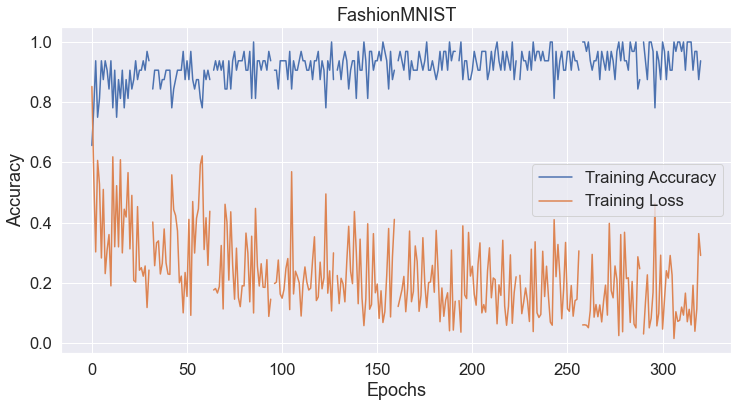

In [24]:
#print(model.history.keys())
plt.figure(figsize=(12,6))
# summarize history for accuracy
plt.plot(df.train_acc)
plt.plot(df.train_loss)
plt.title('FashionMNIST')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy', 'Training Loss'], loc='center right')
plt.savefig('Results\\FashionMNIST_history.png')
plt.show()

## Shows some of FashionMNIST data

In [12]:
import itertools
batch_size = 2
sample_at = 5
k = int(np.floor(sample_at/batch_size))

tensor([4, 1, 0, 1, 1, 6, 0, 8, 3, 6, 8, 4, 5, 2, 0, 5, 2, 8, 1, 7, 8, 9, 1, 2,
        9, 0, 2, 6, 5, 2, 8, 0, 9, 0, 8, 6, 0, 6, 3, 8, 7, 4, 7, 2, 2, 7, 9, 6,
        3, 5, 0, 5, 5, 3, 0, 0, 3, 7, 4, 1, 2, 9, 1, 6])


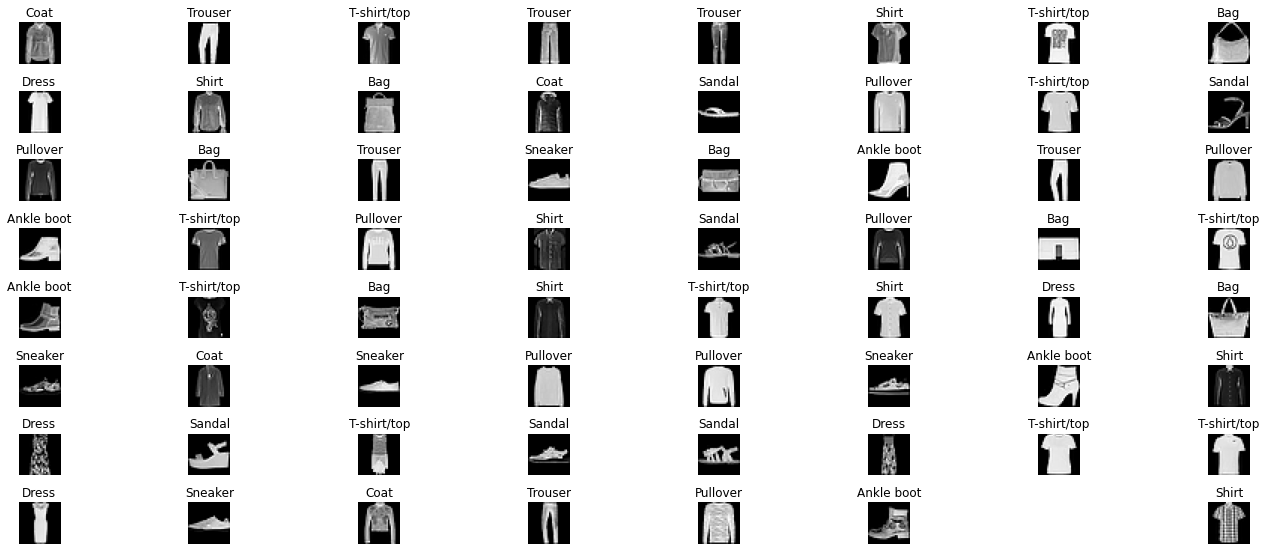

In [14]:
import itertools
k = int(np.floor(sample_at/batch_size))
transform = transforms.Compose([transforms.ToTensor()])
#data = MNIST(".", train=False, download=True, transform=transform)
data=copy.deepcopy(dataset_train)
dataloader = DataLoader(data, batch_size=64)
my_sample = next(itertools.islice(dataloader, k, None))
print (my_sample[1])

class_names=['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
plt.figure(figsize=(20,8))
for i in range(64):
    plt.subplot(8,8,i+1)
    arr=np.squeeze(data)
    plt.imshow(my_sample[0][i][0], cmap='gray')
    plt.tight_layout()
    plt.axis('off')
    idex=my_sample[1][i].item()
    plt.title(class_names[idex])

#dataloader = DataLoader(data, batch_size=32)

## prepare_test_embeddings

In [10]:
def prepare_test_embeddings(dataset_train):
    #transform = transforms.Compose([transforms.ToTensor()])
    #data=dataset_train
    dataloader = DataLoader(dataset_train, batch_size=32)
    #test_imgs = torch.zeros((0, 1, 28, 28), dtype=torch.float32)
    test_predictions = []
    test_targets = []
    test_embeddings = torch.zeros((0, 50), dtype=torch.float32)
    for x,y in dataloader:
        #x = x.cpu()
        embeddings, logits = model(x)
        preds = torch.argmax(logits, dim=1)
        test_predictions.extend(preds)#.detach().cpu().tolist())
        test_targets.extend(y)#.detach().cpu().tolist())
        test_embeddings = torch.cat((test_embeddings, embeddings.detach().cpu()), 0)
        #test_imgs = torch.cat((test_imgs, x.detach().cpu()), 0)
    #test_imgs = np.array(test_imgs)
    test_embeddings = np.array(test_embeddings)
    test_targets = np.array(test_targets)
    test_predictions = np.array(test_predictions)
    
    test_acc = np.sum(test_predictions == test_targets)
    final_test_acc = test_acc/len(test_embeddings)
    
    accuracy = accuracy_score(test_predictions, test_targets)#,average='micro')
    recall = recall_score(test_predictions, test_targets,average='micro')
    precision = precision_score(test_predictions, test_targets,average='micro')
    f1_score1 = f1_score(test_predictions, test_targets,average='micro')
    
    print(f'Accuracy: {accuracy*100:.2f}%')
    print(f'precision: {precision*100:.2f}%')
    print(f'recall: {recall*100:.2f}%')
    print(f'f1_score1: {f1_score1*100:.2f}%')
    
    return test_embeddings,test_targets,test_predictions,final_test_acc
#test_embeddings,test_targets,final_test_acc=prepare_test_embeddings(dataset_train)

In [11]:
# calculates precision for 1:100 dataset with 90 tp and 30 fp
from sklearn.metrics import precision_score,accuracy_score
# calculates recall for 1:100 dataset with 90 tp and 10 fn
from sklearn.metrics import recall_score
# calculates f1 for 1:100 dataset with 95tp, 5fn, 55fp
from sklearn.metrics import f1_score

In [14]:
data_test = FashionMNIST(".", train=False, download=True, transform=transform)
test_embeddings,test_targets,test_predictions,final_test_accfinal_test_acc=prepare_test_embeddings(data_test)
print('Initial Testing accuracy:  ',final_test_acc)

Accuracy: 90.73%
precision: 90.73%
recall: 90.73%
f1_score1: 90.73%
Initial Testing accuracy:   0.9073


In [15]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
#print(accuracy_score(test_targets,test_predictions, average='macro'))
c_matrix = metrics.confusion_matrix(test_targets,test_predictions)
print(metrics.classification_report(test_targets,test_predictions, digits=3))

              precision    recall  f1-score   support

           0      0.874     0.853     0.863      1000
           1      0.994     0.980     0.987      1000
           2      0.853     0.879     0.866      1000
           3      0.847     0.955     0.898      1000
           4      0.842     0.866     0.854      1000
           5      0.984     0.970     0.977      1000
           6      0.797     0.652     0.717      1000
           7      0.947     0.974     0.960      1000
           8      0.955     0.986     0.970      1000
           9      0.972     0.958     0.965      1000

    accuracy                          0.907     10000
   macro avg      0.906     0.907     0.906     10000
weighted avg      0.906     0.907     0.906     10000



In [25]:
import seaborn as sns
def confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        sns.set(font_scale=1.5)
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d",cmap="cividis")#cividis
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')

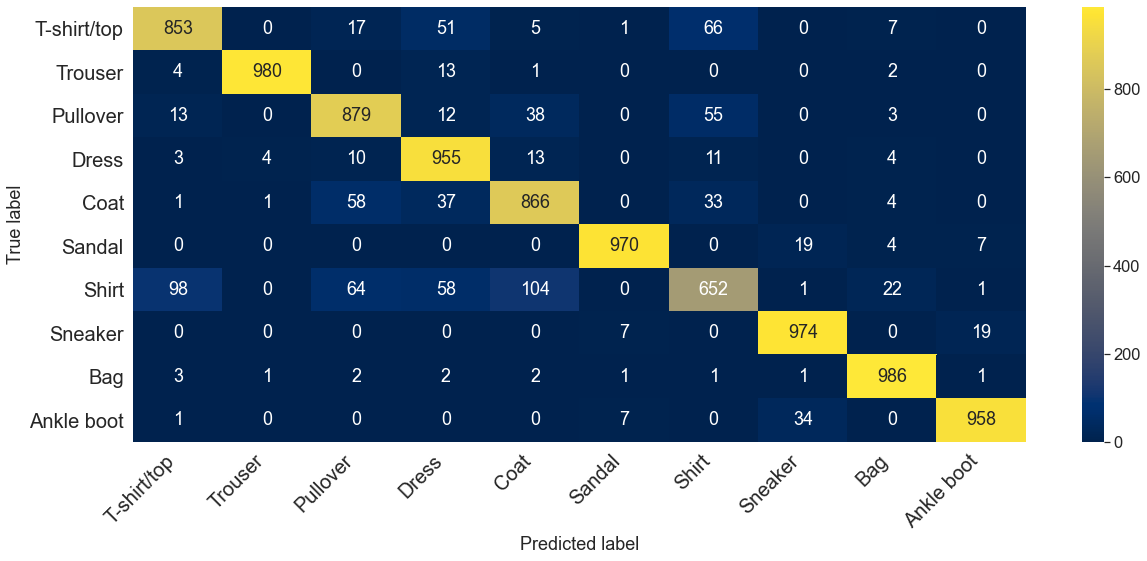

In [26]:
class_names=['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
confusion_matrix(c_matrix, class_names, figsize = (20,8), fontsize=20)